## Advanced RAG - Retrieval Strategies
### Dense, Sparse, Hybrid, and Reranking

**Learning Objectives:**
- Understand different retrieval modes
- Implement hybrid search with filters
- Apply reranking for better results
- Build reusable retrieval functions

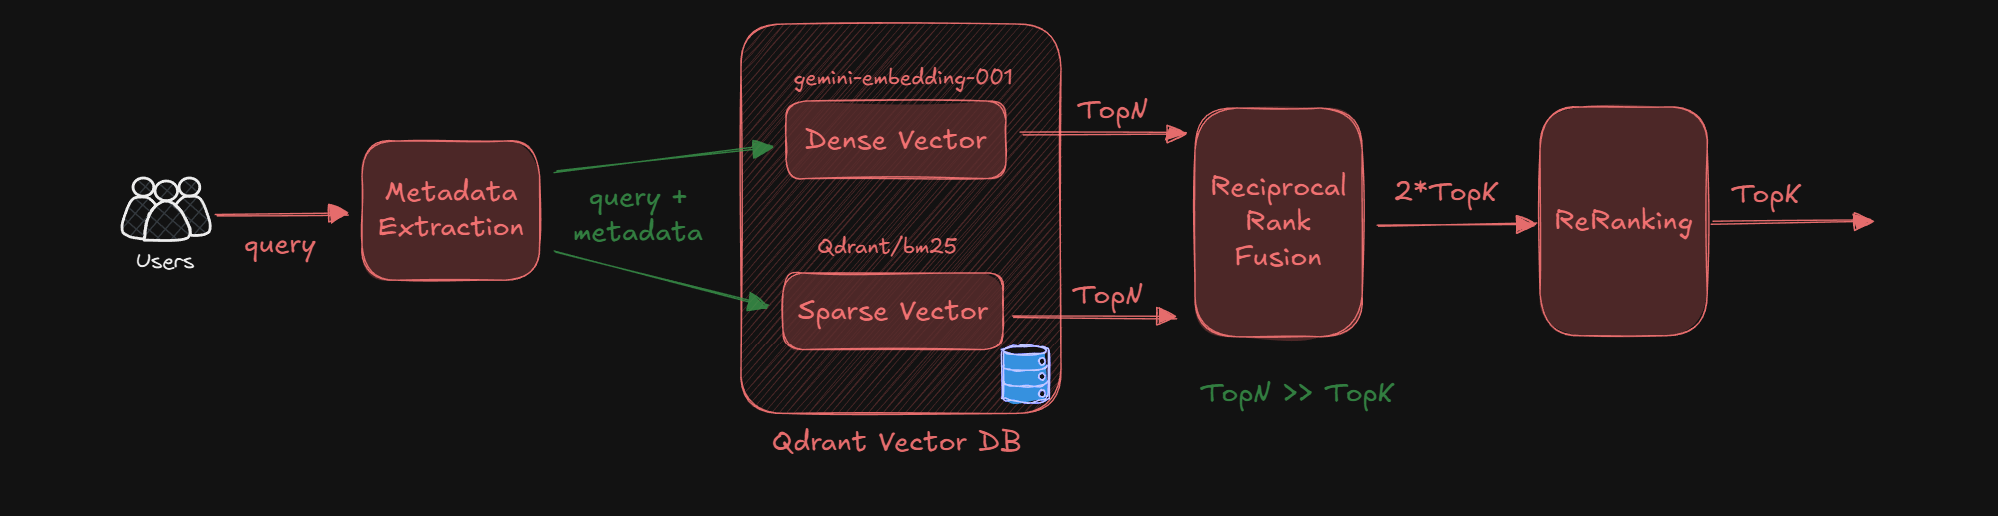
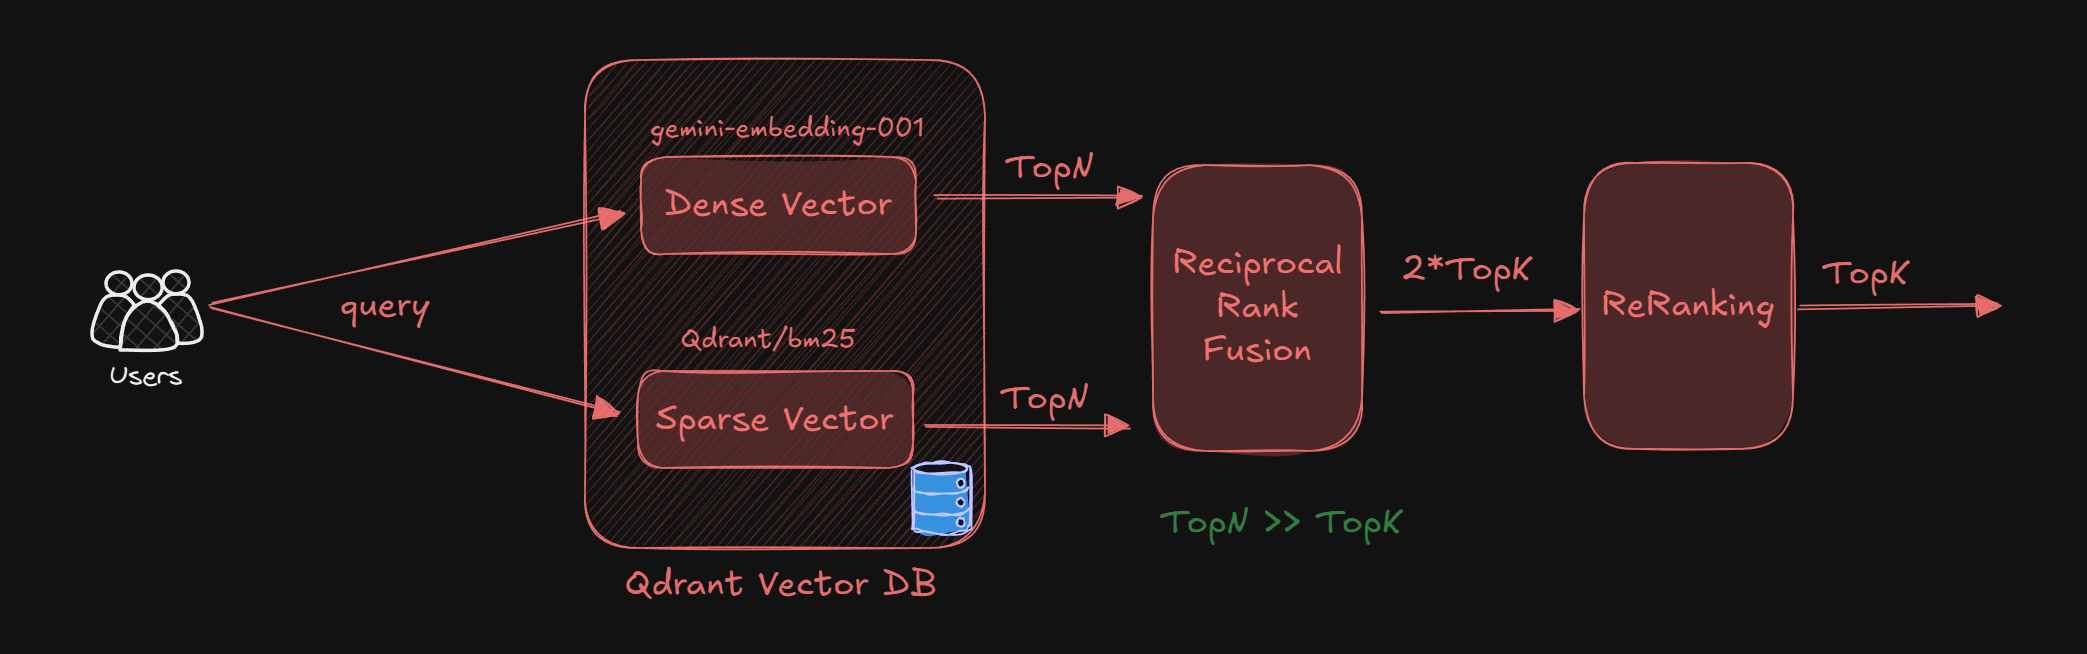

In [ ]:
from dotenv import load_dotenv
load_dotenv()

from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain_qdrant import QdrantVectorStore, RetrievalMode, FastEmbedSparse

from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from qdrant_client.models import Filter, FieldCondition, MatchValue

from scripts.schema import ChunkMetadata

In [ ]:
# Configuration
COLLECTION_NAME = "financial_docs"
EMBEDDING_MODEL = "models/gemini-embedding-001"
LLM_MODEL = "gemini-2.5-flash"

RERANKER_MODEL = "BAAI/bge-reranker-base"

### Initialize LLM and Vector Store

In [ ]:
# Initialize LLM
llm = ChatGoogleGenerativeAI(model=LLM_MODEL)

# Gemini embeddings
embeddings = GoogleGenerativeAIEmbeddings(model=EMBEDDING_MODEL)

# Sparse embeddings
sparse_embeddings = FastEmbedSparse(model_name="Qdrant/bm25")

# Connect to existing collection
vector_store = QdrantVectorStore.from_existing_collection(
    embedding=embeddings,
    sparse_embedding=sparse_embeddings,
    collection_name=COLLECTION_NAME,
    url="http://localhost:6333",
    retrieval_mode=RetrievalMode.HYBRID
)

### Filter Extraction with LLM

In [ ]:
def extract_filters(user_query: str):
    """
    Extract metadata filters from natural language query using LLM.
    
    Args:
        user_query: Natural language query from user
    
    Returns:
        Dictionary with extracted filters (only non-None values)
    """
    llm_structured = llm.with_structured_output(ChunkMetadata)
    
    prompt = f"""Extract metadata filters from the query. Return None for fields not mentioned.

                USER QUERY: {user_query}

                COMPANY MAPPINGS:
                - Amazon/AMZN -> amazon
                - Google/Alphabet/GOOGL/GOOG -> google
                - Apple/AAPL -> apple
                - Microsoft/MSFT -> microsoft
                - Tesla/TSLA -> tesla
                - Nvidia/NVDA -> nvidia
                - Meta/Facebook/FB -> meta

                DOC TYPE:
                - Annual report -> 10-k
                - Quarterly report -> 10-q
                - Current report -> 8-k

                EXAMPLES:
                "Amazon Q3 2024 revenue" -> {{"company_name": "amazon", "doc_type": "10-q", "fiscal_year": 2024, "fiscal_quarter": "q3"}}
                "Apple 2023 annual report" -> {{"company_name": "apple", "doc_type": "10-k", "fiscal_year": 2023}}
                "Tesla profitability" -> {{"company_name": "tesla"}}

                Extract metadata:
                """
    
    metadata = llm_structured.invoke(prompt)
    filters = metadata.model_dump(exclude_none=True)
    
    return filters

### Retrieval Functions

In [ ]:
def hybrid_search(query: str, k: int = 5, filters: dict = None):
    """
    Perform hybrid search (dense + sparse vectors).
    
    Args:
        query: Search query
        k: Number of results
        filters: Optional filters like {"company_name": "amazon", "fiscal_year": 2024}
    
    Returns:
        List of Document objects
    """
    qdrant_filter = None
    
    if filters:
        conditions = [
            FieldCondition(key=f"metadata.{key}", match=MatchValue(value=value))
            for key, value in filters.items()
        ]
        qdrant_filter = Filter(must=conditions)
    
    results = vector_store.similarity_search(query, k=k, filter=qdrant_filter)
    return results

In [ ]:
def rerank_results(query: str, documents: list, top_k: int = 5):
    """
    Rerank documents using cross-encoder.
    
    Args:
        query: Search query
        documents: List of Document objects
        top_k: Number of top results to return
    
    Returns:
        List of (score, Document) tuples sorted by relevance
    """
    reranker = HuggingFaceCrossEncoder(model_name=RERANKER_MODEL)
    query_doc_pairs = [(query, doc.page_content) for doc in documents]
    scores = reranker.score(query_doc_pairs)
    reranked = sorted(zip(scores, documents), key=lambda x: x[0], reverse=True)
    return reranked[:top_k]

In [ ]:
def retrieve_with_reranking(query: str, k: int = 10, top_k: int = 5, filters: dict = None):
    """
    Complete retrieval pipeline: hybrid search + reranking.
    
    Args:
        query: Search query
        k: Number of results to fetch before reranking
        top_k: Number of results to return after reranking
        filters: Optional filters
    
    Returns:
        List of (score, Document) tuples
    """
    # Step 1: Hybrid search
    initial_results = hybrid_search(query, k=k, filters=filters)
    
    # Step 2: Rerank
    reranked = rerank_results(query, initial_results, top_k=top_k)
    
    return reranked

### Test Filter Extraction

In [ ]:
# Test filter extraction
test_queries = [
    "Amazon Q3 2024 revenue",
    "Apple 2023 annual report"
]

for query in test_queries:
    filters = extract_filters(query)
    print(f"Query: {query}")
    print(f"Filters: {filters}\n")

### Example: Dynamic Filters + Reranking

In [ ]:
user_query = "Show me Apples's revenue tables for 2023"

# Extract filters
filters = extract_filters(user_query)
print(f"Extracted filters: {filters}\n")

# Retrieve with reranking
reranked_results = retrieve_with_reranking(
    query=user_query,
    k=10,
    top_k=5,
    filters=filters
)